구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


여러가지 임포트할 것들

In [2]:
from __future__ import print_function
import os
data_path = ['/content/drive/MyDrive/Class4-Regularization_and_Gradient_Descent/Class4-Regularization_and_Gradient_Descent/data']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import LeaveOneOut


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

# from sklearnex import patch_sklearn
# patch_sklearn()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

데이터 받아오기

In [3]:
filepath = os.sep.join(data_path + ['CarPrice_Assignment.csv'])
data = pd.read_csv(filepath, sep=',')

자동차 이름 부분 파싱 후 원핫 인코딩

트레인 데이터와 테스트 데이터 나누기 (7 : 3)

In [4]:
# 자동차 이름 부분 파싱하기

for i in range(205) :
    data['CarName'][i] = data['CarName'][i].split(" ")[0]




# one hot encoding 하기

# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])

# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols)




# train과 test 나누기

train, test = train_test_split(data, test_size=0.3, random_state=42)

<ipython-input-4-878711b89ada>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CarName'][i] = data['CarName'][i].split(" ")[0]


float형인 애들의 편향성 체크하기

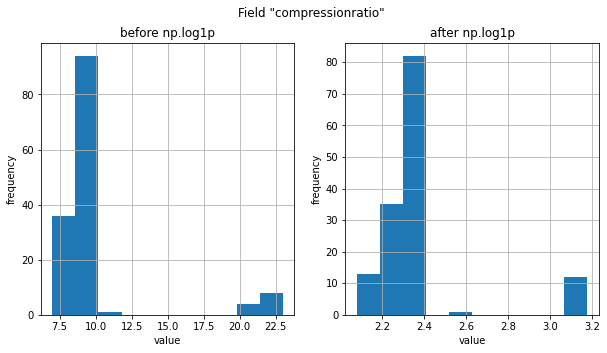

In [5]:
# 데이터의 편향성 체크

# Create a list of float colums to check for skewing
mask = data.dtypes == float
float_cols = data.columns[mask]

skew_limit = 0.75
skew_vals = train[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))




# 편향성 확인해보기

skew_cols
# OPTIONAL: Let's look at what happens to one of these features, when we apply np.log1p visually.

field = "compressionratio"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))
train[field].hist(ax=ax_before)
train[field].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));
# a little bit better




# 전부 로그 취해주기

# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

for col in skew_cols.index.tolist():
    if col == "price":
        continue
    train[col] = np.log1p(train[col])
    test[col]  = test[col].apply(np.log1p)  # same thing

데이터들에서 label 떼어주기

In [8]:
feature_cols = [x for x in train.columns if x != 'price']

mask = train[feature_cols].dtypes == float
float_columns = train[feature_cols].columns[mask]

# 민맥스 스케일러에서 사용할 데이터 만들어두기
train_scaled_mms = train.copy()
test_scaled_mms = test.copy()

scaler = MinMaxScaler()
train_scaled_mms[float_columns] = scaler.fit_transform(train[float_columns])
test_scaled_mms[float_columns] = scaler.transform(test[float_columns])

X_train_scaled_mms = train_scaled_mms[feature_cols].to_numpy()
y_train_scaled_mms = train_scaled_mms['price'].to_numpy()

X_test_scaled_mms = test_scaled_mms[feature_cols].to_numpy()
y_test_scaled_mms = test_scaled_mms['price'].to_numpy()

# 스탠다드 스케일러에서 사용할 데이터 만들어두기
train_scaled_ss = train.copy()
test_scaled_ss = test.copy()

scaler = StandardScaler()
train_scaled_ss[float_columns] = scaler.fit_transform(train[float_columns])
test_scaled_ss[float_columns] = scaler.transform(test[float_columns])

X_train_scaled_ss = train_scaled_ss[feature_cols].to_numpy()
y_train_scaled_ss = train_scaled_ss['price'].to_numpy()

X_test_scaled_ss = test_scaled_ss[feature_cols].to_numpy()
y_test_scaled_ss = test_scaled_ss['price'].to_numpy()





# train, test 데이터들에서 레이블 떼어주기

X_train = train[feature_cols].to_numpy()
y_train = train['price'].to_numpy()

X_test  = test[feature_cols].to_numpy()
y_test  = test['price'].to_numpy()

오류는 일단 송 팀에 맞춰서 루트 씌운걸로 사용

In [9]:
# mse로 하던가, 루트 씌워서 하던가
# 일단 루트 씌워서

"""
def rmse(ytrue, ypredicted):
    return mean_squared_error(ytrue, ypredicted)
"""


def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))


loocv 불러두기

In [10]:
# loocv 위한 준비

loocv = LeaveOneOut()

리니어 리그레이션: 스케일러 없이

3160.4582078906374


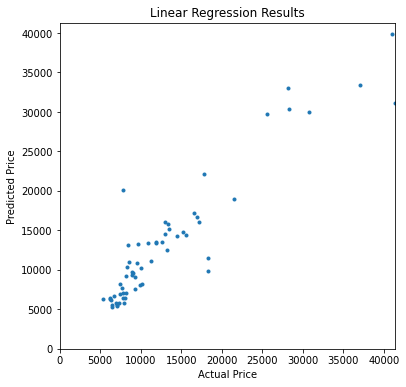

In [11]:
# 리니어 리그레이션

linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))




# 결과 출력

print(linearRegression_rmse)

f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

라쏘 리그레이션: 스케일러 없이

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90141312.25424033, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89460749.17322233, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89358035.8540778, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning:

0.0005 2750.4840899995415


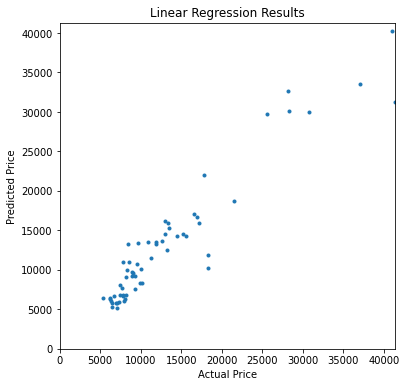

In [12]:
# 라쏘 리그레이션

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  cv=loocv).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))



# 결과 출력

print(lassoCV.alpha_, lassoCV_rmse)

f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, lassoCV.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

In [13]:
# 몇 개의 특징들이 걸러졌는지

print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Of 81 coefficients, 77 are non-zero with Lasso.


스케일러 없는 리니어와 라쏘 비교

In [14]:
# 결과들 비교

rmse_vals = [linearRegression_rmse, lassoCV_rmse]

labels = ['Linear', 'Lasso']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,3160.458208
Lasso,2750.484090


민맥스 스케일러 적용

In [15]:
# 민맥스 스케일러

"""
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

new_rmses = {}
linearRegression = LinearRegression().fit(X_train_scaled_mms, y_train_scaled_mms)

new_rmses['Linear'] = rmse(y_test_scaled_mms, linearRegression.predict(X_test_scaled_mms))


alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                cv= loocv).fit(X_train_scaled_mms, y_train_scaled_mms)
new_rmses['Lasso'] = rmse(y_test_scaled_mms, lassoCV.predict(X_test_scaled_mms))

rmse_df['RMSE-MinMax'] = pd.Series(new_rmses)
rmse_df

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90139046.96014461, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89460324.28740154, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89357812.06636356, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning

,RMSE,RMSE-MinMax
Linear,3160.458208,3160.458208
Lasso,2750.484090,2750.489318


스탠다드 스케일러 적용

In [16]:
# 스탠다드 스케일러
"""
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

new_rmses = {}
# following notation passes the dict items as arguments
linearRegression = LinearRegression().fit(X_train_scaled_ss, y_train_scaled_ss)

new_rmses['Linear'] = rmse(y_test_scaled_ss, linearRegression.predict(X_test_scaled_ss))


alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                cv=loocv).fit(X_train_scaled_ss, y_train_scaled_ss)
new_rmses['Lasso'] = rmse(y_test_scaled_ss, lassoCV.predict(X_test_scaled_ss))

rmse_df['RMSE-Standard'] = pd.Series(new_rmses)
rmse_df

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90138058.90041244, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89460124.39591068, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89357709.81021276, tolerance: 871109.4608232392
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning

,RMSE,RMSE-MinMax,RMSE-Standard
Linear,3160.458208,3160.458208,3160.458208
Lasso,2750.484090,2750.489318,2750.476600
